In [2]:
import sympy as sp
import numpy as np
from scipy.linalg import expm
from sympy.utilities.lambdify import lambdify


In [2]:
# Define the symbolic variables
om1, om2, ru, rv, phi, t1, t2, tau = sp.symbols('om1 om2 ru rv phi t1 t2 tau', real=True)

t_v = sp.Matrix([t1, t2])

# Define the matrix
M = sp.Matrix([[-1j*om1 - ru**2, -ru*rv*sp.exp(-1j * phi)], [-ru*rv*sp.exp(1j * phi), -1j*om2 - rv**2]])

# Compute the matrix exponential
expm_M = sp.exp(M * tau)


In [36]:
symbolic_system = (t_v.T * expm_M * t_v)[0,0]

In [34]:
symbolic_system

t1*(t1*(2.0*I*(0.176776695296637*om1**2*(-0.5*om1**2 + om1*om2 + I*om1*ru**2 - I*om1*rv**2 - 0.5*om2**2 - I*om2*ru**2 + I*om2*rv**2 + 0.5*ru**4 + ru**2*rv**2 + 0.5*rv**4)**1.5*exp(I*phi) - 0.353553390593274*om1*om2*(-0.5*om1**2 + om1*om2 + I*om1*ru**2 - I*om1*rv**2 - 0.5*om2**2 - I*om2*ru**2 + I*om2*rv**2 + 0.5*ru**4 + ru**2*rv**2 + 0.5*rv**4)**1.5*exp(I*phi) - 0.353553390593274*I*om1*ru**2*(-0.5*om1**2 + om1*om2 + I*om1*ru**2 - I*om1*rv**2 - 0.5*om2**2 - I*om2*ru**2 + I*om2*rv**2 + 0.5*ru**4 + ru**2*rv**2 + 0.5*rv**4)**1.5*exp(I*phi) + 0.353553390593274*I*om1*rv**2*(-0.5*om1**2 + om1*om2 + I*om1*ru**2 - I*om1*rv**2 - 0.5*om2**2 - I*om2*ru**2 + I*om2*rv**2 + 0.5*ru**4 + ru**2*rv**2 + 0.5*rv**4)**1.5*exp(I*phi) + 0.176776695296637*om2**2*(-0.5*om1**2 + om1*om2 + I*om1*ru**2 - I*om1*rv**2 - 0.5*om2**2 - I*om2*ru**2 + I*om2*rv**2 + 0.5*ru**4 + ru**2*rv**2 + 0.5*rv**4)**1.5*exp(I*phi) + 0.353553390593274*I*om2*ru**2*(-0.5*om1**2 + om1*om2 + I*om1*ru**2 - I*om1*rv**2 - 0.5*om2**2 - I*om2*ru

In [38]:
symbolic_system_func = lambdify((om1, om2, ru, rv, phi, t1, t2, tau), symbolic_system)

In [41]:
import dill
with open('data/2_boson_system.pkl', 'wb') as outf:
    dill.dump(symbolic_system, outf)

In [6]:
import dill
om1, om2, ru, rv, phi, t1, t2, tau = sp.symbols('om1 om2 ru rv phi t1 t2 tau', real=True)
with open('data/2_boson_system.pkl', 'rb') as outf:
    symbolic_system = dill.loads(outf.read())
    symbolic_system_func = lambdify((om1, om2, ru, rv, phi, t1, t2, tau), symbolic_system)

## scipy

In [14]:
from numba import njit
import numpy as np
from scipy.linalg import expm
from scipy.optimize import minimize, Bounds
from concurrent.futures import ThreadPoolExecutor
import matplotlib.pyplot as plt
import time

def time_function(func):
    def wrapper(*args, **kwargs):
        start_time = time.time()
        result = func(*args, **kwargs)
        end_time = time.time()
        elapsed_time = end_time - start_time
        print(f"Function '{func.__name__}' took {elapsed_time:.6f} seconds")
        return result
    return wrapper
# @time_function
@njit
def get_M(w1, w2, y1, y2, phi):
    y3 = np.sqrt(y1 * y2)
    return np.array([[-1j * w1 - y1, -y3 * np.exp(-1j * phi)],
                     [-y3 * np.exp(-1j * phi), -1j * w2 - y2]])
# @time_function
def get_Eta(t, t1, t2, w1, w2, y1, y2, phi):
    M = get_M(w1, w2, y1, y2, phi)
    vec = np.array([t1, t2])
    M_exp = expm(M * t)  # Perform matrix exponentiation outside njit

    # Perform matrix-vector multiplication with consistent types
    return np.dot(np.dot(vec, M_exp), vec.T)
# @time_function
@njit(fastmath=True)
def get_trueEta(t, mu):
    return 1 / (t**2 + mu**2)


params_num = 7

def loss_func(flat_params, t):
    params = np.array(flat_params).reshape(-1, params_num)
    mu = 0.5

    t1, t2, w1, w2, y1, y2, phi = params.T
    etas = np.array([get_Eta(t, t1[i], t2[i], w1[i], w2[i], y1[i], y2[i], phi[i]) for i in range(len(t1))])
    sum_eta = np.sum(etas)
    total_loss = abs((get_trueEta(t, mu) - sum_eta))

    return total_loss


def optimize_for_t(t, flat_initial_params, bounds):
    res = minimize(loss_func, flat_initial_params, args=(t,), method="COBYLA", bounds=bounds)
    return res

delta_t = 0.05

number_of_modes = 20

In [15]:
# Initial guess for params (flattened list of real numbers)

initial_params = np.random.random((number_of_modes, params_num))

# Flatten the initial parameters for optimization
flat_initial_params = initial_params.flatten()

# Define the bounds for the parameters (non-negative)
bounds = Bounds(([np.inf] * (params_num - 1)+[0]) * number_of_modes, ([np.inf] * (params_num - 1)+[2*np.pi])*number_of_modes)

# Perform the optimization
losses = []
time_values = np.arange(0, 30, delta_t)

# scipy
with ThreadPoolExecutor() as executor:
    losses = list(executor.map(lambda t: optimize_for_t(t, flat_initial_params, bounds), time_values))

# tensorflow
# with ThreadPoolExecutor() as executor:
#     losses = list(executor.map(lambda t: optimize_with_adam(optimizer, t, flat_initial_params), time_values))

# optimize_with_adam(optimizer, 1, flat_initial_params)

# for t in time_values:
#     res = minimize(loss_func, flat_initial_params, args=(t),method="COBYLA", bounds=bounds)
#     losses.append(res.fun)

# Plot the losses over time
# Output the result
# optimized_params = res.x.reshape(-1, 7)
# print("Optimized loss:", res.fun)


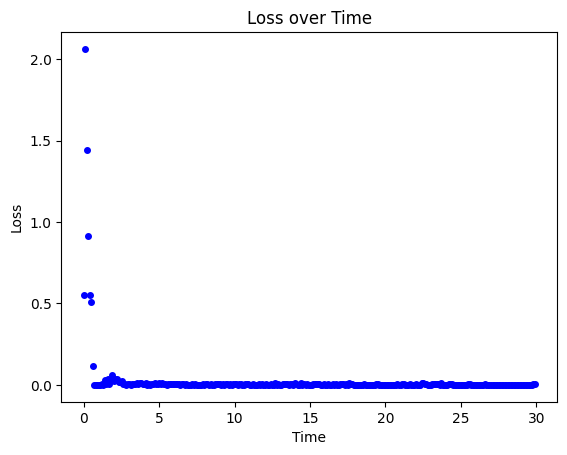

In [24]:
plt.plot(time_values[:], [loss_ for loss_ in losses][:], 'bo', markersize=4)
plt.xlabel('Time')
plt.ylabel('Loss')
plt.title('Loss over Time')
plt.show()

res = losses[0]

In [23]:
error = delta_t * np.sum([loss_ for loss_ in losses][8:])
error

0.11609592607188267

AttributeError: 'numpy.float64' object has no attribute 'x'

## TORCH

In [193]:
from numba import njit
import numpy as np
from scipy.linalg import expm
import optax
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import torch
from torch import optim
from torch import jit, chunk, func

# Define helper functions compatible with PyTorch
def get_M_tensor(w1, w2, y1, y2, phi):
    # y3 = torch.sqrt(y1 * y2)
    # M = torch.tensor([
    #     [-1j * w1 - y1, -y3 * torch.exp(-1j * phi)],
    #     [-y3 * torch.exp(-1j * phi), -1j * w2 - y2]
    # ], dtype=torch.complex128)
    # return M
    y3 = torch.sqrt(y1 * y2)
    M = torch.stack([
        torch.complex(-w1, -y1), -y3 * torch.exp(-1j * phi)
    ], dim=0)
    M = torch.stack([M, torch.stack([
        -y3 * torch.exp(-1j * phi), torch.complex(-w2, -y2)
    ], dim=0)], dim=1)
    return M

# def get_Eta_tensor(t, t1, t2, w1, w2, y1, y2, phi):
#     M = get_M_tensor(w1, w2, y1, y2, phi)
#     vec = torch.stack([t1, t2], dim=0).type(torch.complex128)

#     M_exp = torch.linalg.matrix_exp(M * t)

#     # Perform matrix-vector multiplication
#     result = torch.matmul(vec.conj(), torch.matmul(M_exp, vec))
#     return result
def eta_from_params12(time_grid, params):
    params = params.view(-1, 7)
    t1, t2, w1, w2, y1, y2, phi = torch.chunk(params, chunks=7, dim=1)
    #t1 = torch.clamp(t1, min=0)  # Apply non-negative constraint to t1
    #omega = torch.remainder(omega, 2 * np.pi)  # Apply periodic constraint to omega
    # gamma = torch.clamp(gamma, min=0)  # Apply non-negative constraint to gamma
    # print(t1.size())

    vec = torch.stack([t1, t2], dim=0).type(torch.complex64)
    M = get_M_tensor(w1, w2, y1, y2, phi).type(torch.complex64)
    M = M.permute(3, 2, 0, 1)
    M = M[0]
    # M = M.reshape(1, -1, 2, 2)
    vec = vec.permute(2, 0, 1)
    vec = vec[0]
    # Element-wise multiplication
    results = []
    for t in time_grid:
        M_exp = torch.linalg.matrix_exp(t * M)
        print(M_exp.size())
        print(vec.size())
        result = torch.matmul(vec.expand(4, 2, 4), torch.matmul(M_exp, vec.expand(4, 2, 4).conj()))
        print(result.size())

        results.append(result)
    
    results = torch.stack(results)
    print(results.size())
    # Perform matrix-vector multiplication
    

    return torch.sum(results)

def eta_from_params1(time_grid, params):
    params = params.view(-1, 3)
    t1 , omega , gamma = torch.chunk(params, chunks=3, dim=1)
    #t1 = torch.clamp(t1, min=0)  # Apply non-negative constraint to t1
    #omega = torch.remainder(omega, 2 * np.pi)  # Apply periodic constraint to omega
    gamma = torch.clamp(gamma, min=0)  # Apply non-negative constraint to gamma

    return torch.sum(torch.exp(-gamma * time_grid) * t1 * torch.exp(-1j * omega * time_grid), dim= 0)

def loss_func_torch(params, time_grid):
    mu = 0.5
    # Use complex values for t1 and t2
    #eta_probe = time_grid.clone().apply_(lambda t: sum_eta(t, params))
    true_eta = 1/(time_grid**2 + mu**2)
    total_loss = delta_t * torch.sum(torch.abs(true_eta - eta_from_params1(time_grid, params))) #loss function for a single mode
    # total_loss = delta_t * torch.sum(torch.abs(true_eta - eta_from_params12(time_grid, params))) #loss function for double mode

    return total_loss

def optimize_for_t_torch(t, flat_initial_params, num_iterations=10**5):
    # Create tensor with requires_grad set to True
    params = torch.tensor(flat_initial_params, dtype=torch.float64, requires_grad=True)
    optimizer = optim.Adam([params], lr=1e-4)

    # Use tensor for loss computation
    loss = torch.tensor(float('inf'), dtype=torch.float64, requires_grad=False)

    for i in range(num_iterations):  # Number of iterations
        optimizer.zero_grad()

        # Compute loss and ensure it requires gradient
        loss = loss_func_torch(params, t)
        loss.requires_grad_()
        loss.backward()
        optimizer.step()
        if i%100 == 0:
            print(loss.item())

    return params

In [305]:
from numba import njit
import numpy as np
from scipy.linalg import expm
import optax
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import torch
from torch import optim
from torch import jit, chunk, func
from typing import List

# Define helper functions compatible with PyTorch
def get_M_tensor(w1, w2, y1, y2, phi):
    # y3 = torch.sqrt(y1 * y2)
    # M = torch.tensor([
    #     [-1j * w1 - y1, -y3 * torch.exp(-1j * phi)],
    #     [-y3 * torch.exp(-1j * phi), -1j * w2 - y2]
    # ], dtype=torch.complex128)
    # return M
    y3 = torch.sqrt(y1 * y2)
    M = torch.stack([
        torch.stack([-1j * w1 - y1, -y3 * torch.exp(-1j * phi)], dim=-1),
        torch.stack([-y3 * torch.exp(-1j * phi), -1j * w2 - y2], dim=-1)
    ], dim=-2).squeeze()  # Shape: (N, 2, 2)
    # print(M.size())
    return M

# def get_Eta_tensor(t, t1, t2, w1, w2, y1, y2, phi):
#     M = get_M_tensor(w1, w2, y1, y2, phi)
#     vec = torch.stack([t1, t2], dim=0).type(torch.complex128)

#     M_exp = torch.linalg.matrix_exp(M * t)

#     # Perform matrix-vector multiplication
#     result = torch.matmul(vec.conj(), torch.matmul(M_exp, vec))
#     return result
@jit.script
def eta_from_params12(time_grid, params):
    params = params.view(-1, 7)
    t1, t2, w1, w2, y1, y2, phi = torch.chunk(params, chunks=7, dim=1)
    #t1 = torch.clamp(t1, min=0)  # Apply non-negative constraint to t1
    #omega = torch.remainder(omega, 2 * np.pi)  # Apply periodic constraint to omega
    # gamma = torch.clamp(gamma, min=0)  # Apply non-negative constraint to gamma
    
    M = get_M_tensor(w1, w2, y1, y2, phi).type(torch.complex64) # (N, 2, 2)
    vec = torch.stack([t1, t2], dim=-1).type(torch.complex64)  # Shape: (N, 1, 2)
    # print(vec.conj().size())

    results = jit.annotate(List[torch.Tensor], [])
    for t in time_grid:
        M_exp = torch.linalg.matrix_exp(t * M)  # Shape: (N, 2, 2) 
        # print(M_exp.size())
        # Matrix multiplication and conjugation
        # M_exp @ vec will be of shape: (N, 2, 1)
        # vec.conj().transpose(-2, -1) @ M_exp @ vec will give (N, 1, 1), i.e., a scalar per sample
        result = torch.matmul(vec.conj(), torch.matmul(M_exp, vec.transpose(-2, -1)))
        # print(result.size())
        results.append(torch.sum(result.squeeze()))  # Remove the extra dimensions


    results = torch.stack(results)

    return results

def eta_from_params1(time_grid, params):
    params = params.view(-1, 3)
    t1 , omega , gamma = torch.chunk(params, chunks=3, dim=1)
    #t1 = torch.clamp(t1, min=0)  # Apply non-negative constraint to t1
    #omega = torch.remainder(omega, 2 * np.pi)  # Apply periodic constraint to omega
    gamma = torch.clamp(gamma, min=0)  # Apply non-negative constraint to gamma

    return torch.sum(torch.exp(-gamma * time_grid) * t1 * torch.exp(-1j * omega * time_grid), dim= 0)

def loss_func_torch(params, time_grid):
    mu = 0.5
    # Use complex values for t1 and t2
    #eta_probe = time_grid.clone().apply_(lambda t: sum_eta(t, params))
    true_eta = 1/(time_grid**2 + mu**2)
    # total_loss = delta_t * torch.sum(torch.abs(true_eta - eta_from_params1(time_grid, params))) #loss function for a single mode
    total_loss = delta_t * torch.sum(torch.abs(true_eta - eta_from_params12(time_grid, params))) #loss function for double mode

    return total_loss

def optimize_for_t_torch(t, flat_initial_params, num_iterations=10**5):
    # Create tensor with requires_grad set to True
    params = torch.tensor(flat_initial_params, dtype=torch.float64, requires_grad=True)
    optimizer = optim.Adam([params], lr=1e-3)

    # Use tensor for loss computation
    loss = torch.tensor(float('inf'), dtype=torch.float64, requires_grad=False)

    for i in range(300):  # Number of iterations
        # if i > 400 and not init_second:
        #     optimizer = optim.Adam([params], lr=1e-4)
        #     init_second=True
        optimizer.zero_grad()

        # Compute loss and ensure it requires gradient
        loss = loss_func_torch(params, t)
        loss.requires_grad_()
        loss.backward()
        optimizer.step()
        if i%100 == 0:
            print(loss.item())
 
    optimizer.param_groups['lr'] = 1e-4

    for i in range(num_iterations):
        optimizer.zero_grad()

        # Compute loss and ensure it requires gradient
        loss = loss_func_torch(params, t)
        loss.requires_grad_()
        loss.backward()
        optimizer.step()
        if i%100 == 0:
            print(loss.item())
        

    return params

In [306]:
def get_M_tensor1(w1, w2, y1, y2, phi):
    y3 = torch.sqrt(y1 * y2)
    M = torch.tensor([
        [-1j * w1 - y1, -y3 * torch.exp(-1j * phi)],
        [-y3 * torch.exp(-1j * phi), -1j * w2 - y2]
    ], dtype=torch.complex64)
    return M

def get_Eta_tensor(t, t1, t2, w1, w2, y1, y2, phi):
    M = get_M_tensor1(w1, w2, y1, y2, phi)
    vec = torch.tensor([t1, t2], dtype=torch.complex64)

    M_exp = torch.matrix_exp(M * t)  # Use SciPy for matrix exponentiation

    result = torch.matmul(vec, torch.matmul(M_exp, vec.conj()))
    return result
def sum_eta12(t,params):
    params = params.view(-1, 7)
    t1, t2, w1, w2, y1, y2, phi = torch.chunk(params, chunks=7, dim=1)
    etas = torch.tensor([get_Eta_tensor(t, t1[i], t2[i], w1[i], w2[i], y1[i], y2[i], phi[i]) for i in range(t1.size(0))], dtype=torch.complex64)
    return torch.sum(etas)
def eta_from_params121(time_grid, params):
    results = []
    for t in range(len(time_grid)):
        results.append(sum_eta12(time_grid[t], params))
    results = torch.stack(results)
    return results
    # return time_grid.clone().apply_(lambda t: sum_eta12(t, params))

In [307]:
delta_t = 0.1
time_grid = torch.arange(0, 30, delta_t)
# print(time_grid.shape)
number_of_modes = 20

# Usage example
# flat_initial_params = np.random.rand(number_of_modes * 3)  # Initializaion for single mode
flat_initial_params = torch.tensor(np.random.rand(number_of_modes * 7))  # Initializaion for double mode
# print(eta_from_params12(time_grid, flat_initial_params))
# print(torch.sum(eta_from_params121(time_grid, flat_initial_params)))
final_params = optimize_for_t_torch(time_grid, flat_initial_params)

/tmp/ipykernel_465644/2192111047.py:87: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  params = torch.tensor(flat_initial_params, dtype=torch.float64, requires_grad=True)


24.7064266204834
10.843367576599121
6.349142074584961


In [63]:
# Initial guess for params (flattened list of real numbers)
initial_params = np.random.random((number_of_modes, 7))

# Flatten the initial parameters for optimization
flat_initial_params = initial_params.flatten()

# Define the bounds for the parameters (non-negative)
bounds = Bounds(([np.inf] * 6+[0]) * number_of_modes, ([np.inf] * 6+[2*np.pi])*number_of_modes)

# Perform the optimization
losses = []
time_values = np.arange(0, 30, delta_t)

# scipy
# with ThreadPoolExecutor() as executor:
#     losses = list(executor.map(lambda t: optimize_for_t(t, flat_initial_params, bounds), time_values))

# tensorflow
# with ThreadPoolExecutor() as executor:
#     losses = list(executor.map(lambda t: optimize_with_adam(optimizer, t, flat_initial_params), time_values))

# JAX
# with ThreadPoolExecutor() as executor:
#     losses = list(executor.map(lambda t: optimize_for_t(t, flat_initial_params), time_values))

optimize_for_t_torch(1, flat_initial_params)
# optimize_with_adam(optimizer, 1, flat_initial_params)

# for t in time_values:
#     res = minimize(loss_func, flat_initial_params, args=(t),method="COBYLA", bounds=bounds)
#     losses.append(res.fun)

# Plot the losses over time
# Output the result
# optimized_params = res.x.reshape(-1, 7)
# print("Optimized loss:", res.fun)


TypeError: stack() got an unexpected keyword argument 'dtype'

In [ ]:
plt.plot(time_values, losses, 'bo', markersize=4)
plt.xlabel('Time')
plt.ylabel('Loss')
plt.title('Loss over Time')
plt.show()

res = losses[0]

In [37]:
def mdd(a, b):
    return a + b


a = np.array([1, 2 ,3])
b = np.array([1, 2 ,3])
mdd(a, b)

array([2, 4, 6])